# Performance comparaison

| Fingerprint | R2 | RMSE |  
|:-:|:-:|:-:|  
| ECFP| 0.765 | 0.9808 |
|Can2Can|0.7176|1.073|
| NFP| 0.8845 | 0.6868 |

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys, AllChem

from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import optuna

ImportError: No module named 'optuna'

In [2]:
df_sol = pd.read_csv('data/solubility.csv')
df_sol.head()

,SMILES,unknown,solubility,processed_smiles
0,O=C(C)N,60-35-5,1.58,O = C ( C ) N
1,NNC,60-34-4,1.34,N N C
2,O=C(C)O,64-19-7,1.22,O = C ( C ) O
3,N1CCCC1,123-75-1,1.15,N 1 C C C C 1
4,O=C(N)NO,127-07-1,1.12,O = C ( N ) N O


# Solubility regression

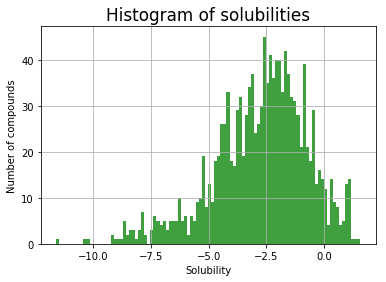

In [4]:
sol = df_sol['solubility'].values 
plt.hist(sol, 100, facecolor='green', alpha=0.75)
plt.rcParams["font.size"]=14
plt.xlabel('Solubility')
plt.ylabel('Number of compounds')
plt.title('Histogram of solubilities')
plt.grid()
plt.show()

In [5]:
def bit2np(bitvector):
    bitstring = bitvector.ToBitString()
    intmap = map(int, bitstring)
    return np.array(list(intmap))

In [6]:
def extract_morgan(df):
    smiles = df["SMILES"].values
    sol = df['solubility'].values
    N = len(smiles)
    print("{} molecules".format(N))
    X,y = [],[]
    for i in range(N):
        mol = Chem.MolFromSmiles(smiles[i])
        if mol is None:
            print(i)
            continue

        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024) # Morgan (Similar to ECFP4)
        X.append(bit2np(fp))
        y.append(sol[i])
    X = np.array(X)
    y = np.array(y)
    return X, y

In [58]:
a = Chem.MolFromSmiles('c1ccccc1 ')
print(a)

In [8]:
X_train, y_train = extract_morgan(pd.read_csv('data/sol_train.csv'))
X_test, y_test = extract_morgan(pd.read_csv('data/sol_test.csv'))
print('Train', X_train.shape)
print('Test', X_test.shape)

968 molecules
322 molecules
306
Train (968, 1024)
Test (321, 1024)


# Prediction
### Multi-layer perceptron

In [43]:
# Default
# Default
n = 10
r2 = np.zeros(n)
mse = np.zeros(n)

for i in range(n):
    MLP = MLPRegressor()
    MLP.fit(X_train, y_train)
    y_pred = MLP.predict(X_test)
    r2[i] = r2_score(y_test, y_pred)
    mse[i] = mean_squared_error(y_test, y_pred)

print("Test R2: {:.4f} ± {:.4f}".format(np.mean(r2), np.std(r2)))
print("Test MSE: {:.4f} ± {:.4f}".format(np.mean(mse), np.std(mse)))

/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

Test R2: 0.6645 ± 0.0191
Test MSE: 1.3707 ± 0.0782


In [44]:
def objective_mlp(trial):
    n_layers = trial.suggest_int('n_layers', 1,3)
    layers = []
    for i in range(n_layers):
        n_units = int(trial.suggest_loguniform('n_units_l{}'.format(i), 1, 1000))
        layers.append(n_units)
    
    n_folds = 4
    score = 0
    for _ in range(n_folds):
        mlp = MLPRegressor(hidden_layer_sizes=layers)
        X_trn, X_val, y_trn, y_val = train_test_split(X_train, y_train)
        mlp.fit(X_trn, y_trn)
        y_pred = mlp.predict(X_val)
        score += mean_squared_error(y_val, y_pred)
    return score/n_folds

study = optuna.create_study()
study.optimize(objective_mlp, n_trials=100)

[I 2019-03-27 14:22:02,951] Finished a trial resulted in value: 1.5416560371445227. Current best value is 1.5416560371445227 with parameters: {'n_layers': 3, 'n_units_l0': 322.5994329335695, 'n_units_l1': 1.6157563239137902, 'n_units_l2': 263.7478858950991}.
[I 2019-03-27 14:23:24,247] Finished a trial resulted in value: 1.346197750418836. Current best value is 1.346197750418836 with parameters: {'n_layers': 1, 'n_units_l0': 977.1515878736769}.
/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/honda/anaconda3/lib/pytho

[I 2019-03-27 14:25:23,565] Finished a trial resulted in value: 1.9114989664609052. Current best value is 1.1357399039491396 with parameters: {'n_layers': 3, 'n_units_l0': 66.70075836766398, 'n_units_l1': 37.989472413427066, 'n_units_l2': 23.183536069461045}.
/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[I 2019-03-27 14:30:36,605] Finished a trial resulted in value: 1.6438376805256016. Current best value is 1.1357399039491396 with parameters: {'n_layers': 3, 'n_units_l0': 66.70075836766398, 'n_units_l1': 37.989472413427066, 'n_units_l2': 23.183536069461045}.
[I 2019-03-27 14:30:48,394] Finished a trial resulted in value: 1.3098928037243194. Current best value is 1.1357399039491396 with parameters: {'n_layers': 3, 'n_units_l0': 66.70075836766398, 'n_units_l1': 37.989472413427066, 'n_units_l2': 23.183536069461045}.
[I 2019-03-27 14:31:05,793] Finished a trial resulted in value: 1.2534836699878529. Current best value is 1.1357399039491396 with parameters: {'n_layers': 3, 'n_units_l0': 66.70075836766398, 'n_units_l1': 37.989472413427

/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[I 2019-03-27 14:38:50,959] Finished a trial resulted in value: 1.5392989913051345. Current best value is 1.1357399039491396 with parameters: {'n_layers': 3, 'n_units_l0': 66.70075836766398, 'n_units_l1': 37.989472413427066, 'n_units_l2': 23.183536069461045}.
/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

[I 2019-03-27 14:47:09,880] Finished a trial resulted in value: 1.4257486402679147. Current best value is 1.1357399039491396 with parameters: {'n_layers': 3, 'n_units_l0': 66.70075836766398, 'n_units_l1': 37.989472413427066, 'n_units_l2': 23.183536069461045}.
[I 2019-03-27 14:47:21,137] Finished a trial resulted in value: 1.4600071526309273. Current best value is 1.1357399039491396 with parameters: {'n_layers': 3, 'n_units_l0': 66.70075836766398, 'n_units_l1': 37.989472413427066, 'n_units_l2': 23.183536069461045}.
[I 2019-03-27 14:47:57,484] Finished a trial resulted in value: 1.2479667293740362. Current best value is 1.1357399039491396 with parameters: {'n_layers': 3, 'n_units_l0': 66.70075836766398, 'n_units_l1': 37.989472413427066, 'n_units_l2': 23.183536069461045}.
[I 2019-03-27 14:48:12,369] Finished a trial resulted in value: 1.2039598123813833. Current best value is 1.1357399039491396 with parameters: {'n_layers': 3, 'n_units_l0': 66.70075836766398, 'n_units_l1': 37.989472413427

/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[I 2019-03-27 15:00:57,746] Finished a trial resulted in value: 1.934418132872151. Current best value is 1.1357399039491396 with parameters: {'n_layers': 3, 'n_units_l0': 66.70075836766398, 'n_units_l1': 37.989472413427066, 'n_units_l2': 23.183536069461045}.
[I 2019-03-27 15:01:17,126] Finished a trial resulted in value: 1.2591149308946599. Current best value is 1.1357399039491396 with parameters: {'n_layers': 3, 'n_units_l0': 66.70075836766398, 'n_units_l1': 37.989472413427066, 'n_units_l2': 23.183536069461045}.
[I 2019-03-27 15:02:27,622] Finished a trial resulted in value: 1.2989809948952806. Current best value is 1.1357399039491396 with parameters: {'n_layers': 3, 'n_units_l0': 66.70075836766398, 'n_units_l1': 37.9894724134270

In [45]:
# Optimized

n = 10
r2 = np.zeros(n)
mse = np.zeros(n)

for i in range(n):
    MLP = MLPRegressor((67,38,23))
    MLP.fit(X_train, y_train)
    y_pred = MLP.predict(X_test)
    r2[i] = r2_score(y_test, y_pred)
    mse[i] = mean_squared_error(y_test, y_pred)

print("Test R2: {:.4f} ± {:.4f}".format(np.mean(r2), np.std(r2)))
print("Test MSE: {:.4f} ± {:.4f}".format(np.mean(mse), np.std(mse)))

Test R2: 0.7150 ± 0.0145
Test MSE: 1.1642 ± 0.0591


### Random Forest

In [47]:
# Default
n = 10
r2 = np.zeros(n)
mse = np.zeros(n)

for i in range(n):
    RF = RandomForestRegressor()
    RF.fit(X_train, y_train)
    y_pred = RF.predict(X_test)
    r2[i] = r2_score(y_test, y_pred)
    mse[i] = mean_squared_error(y_test, y_pred)

print("Test R2: {:.4f} ± {:.4f}".format(np.mean(r2), np.std(r2)))
print("Test MSE: {:.4f} ± {:.4f}".format(np.mean(mse), np.std(mse)))

/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/honda/anaconda3/lib/python3.6/site-package

Test R2: 0.6739 ± 0.0114
Test MSE: 1.3323 ± 0.0467


In [48]:
def objective_rf(trial):
    max_depth = int(trial.suggest_loguniform('max_depth', 2, 100))
    n_estimators = int(trial.suggest_loguniform('n_estimators', 2, 1000))
    max_features = trial.suggest_int('max_features', 1, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        
    n_folds = 4
    score = 0
    for _ in range(n_folds):
        rf = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators, max_features=max_features,
                              min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
        X_trn, X_val, y_trn, y_val = train_test_split(X_train, y_train)
        rf.fit(X_trn, y_trn)
        y_pred = rf.predict(X_val)
        score += mean_squared_error(y_val, y_pred)
    return score/n_folds

study = optuna.create_study()
study.optimize(objective_rf, n_trials=100)

[I 2019-03-27 15:25:32,938] Finished a trial resulted in value: 3.6833128467225267. Current best value is 3.6833128467225267 with parameters: {'max_depth': 3.7795715336911115, 'n_estimators': 265.6365220208648, 'max_features': 7, 'min_samples_split': 10, 'min_samples_leaf': 3}.
[I 2019-03-27 15:25:32,989] Finished a trial resulted in value: 3.5355280577650863. Current best value is 3.5355280577650863 with parameters: {'max_depth': 11.99603018594304, 'n_estimators': 2.842662445985372, 'max_features': 9, 'min_samples_split': 10, 'min_samples_leaf': 7}.
[I 2019-03-27 15:25:33,083] Finished a trial resulted in value: 3.3119433202926203. Current best value is 3.3119433202926203 with parameters: {'max_depth': 26.759767322751497, 'n_estimators': 11.949688228784165, 'max_features': 5, 'min_samples_split': 3, 'min_samples_leaf': 3}.
[I 2019-03-27 15:25:34,165] Finished a trial resulted in value: 2.7409493188671066. Current best value is 2.7409493188671066 with parameters: {'max_depth': 9.614334

[I 2019-03-27 15:26:07,269] Finished a trial resulted in value: 2.2608373398520536. Current best value is 1.44615179930778 with parameters: {'max_depth': 70.99966855193003, 'n_estimators': 26.037612886557305, 'max_features': 6, 'min_samples_split': 2, 'min_samples_leaf': 1}.
[I 2019-03-27 15:26:09,152] Finished a trial resulted in value: 2.991031526962796. Current best value is 1.44615179930778 with parameters: {'max_depth': 70.99966855193003, 'n_estimators': 26.037612886557305, 'max_features': 6, 'min_samples_split': 2, 'min_samples_leaf': 1}.
[I 2019-03-27 15:26:09,335] Finished a trial resulted in value: 2.833185895650168. Current best value is 1.44615179930778 with parameters: {'max_depth': 70.99966855193003, 'n_estimators': 26.037612886557305, 'max_features': 6, 'min_samples_split': 2, 'min_samples_leaf': 1}.
[I 2019-03-27 15:26:09,685] Finished a trial resulted in value: 2.4517082262063212. Current best value is 1.44615179930778 with parameters: {'max_depth': 70.99966855193003, '

In [49]:
# Optimized

n = 10
r2 = np.zeros(n)
mse = np.zeros(n)

for i in range(n):
    RF = RandomForestRegressor(max_depth=71, n_estimators=26, max_features=6,
                              min_samples_split=2, min_samples_leaf=1)
    RF.fit(X_train, y_train)
    y_pred = RF.predict(X_test)
    r2[i] = r2_score(y_test, y_pred)
    mse[i] = mean_squared_error(y_test, y_pred)

print("Test R2: {:.4f} ± {:.4f}".format(np.mean(r2), np.std(r2)))
print("Test MSE: {:.4f} ± {:.4f}".format(np.mean(mse), np.std(mse)))

Test R2: 0.6391 ± 0.0087
Test MSE: 1.4744 ± 0.0355


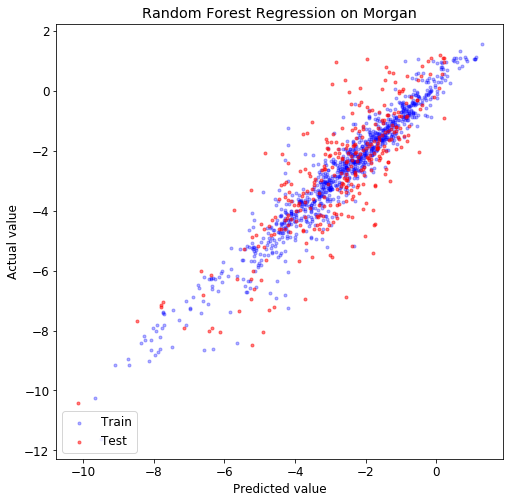

In [15]:
plt.figure(figsize=(8,8))
plt.rcParams["font.size"] = 12
plt.scatter(y_train_pred, y_train, c='blue', marker='.', alpha=0.3, label='Train')
plt.scatter(y_pred, y_test, c='red', marker='.', alpha=0.5, label='Test')
plt.xlabel('Predicted value')
plt.ylabel('Actual value')
plt.title('Random Forest Regression on Morgan')
plt.legend(loc='lower left')
#plt.hlines(y=0, xmin=1, xmax=7, lw=2, color='black')
plt.show()

# DeepChem

In [2]:
import os
import deepchem as dc
from deepchem.models.tensorgraph.models.graph_models import GraphConvModel

In [3]:
graph_featurizer = dc.feat.graph_features.ConvMolFeaturizer()
loader = dc.data.data_loader.CSVLoader( tasks=['solubility'], smiles_field="SMILES", featurizer=graph_featurizer )
trainset = loader.featurize( 'data/sol_train.csv' )
testset = loader.featurize( 'data/sol_test.csv' )

Loading raw samples now.
shard_size: 8192
About to start loading CSV from data/sol_train.csv
Loading shard 1 of size 8192.
Featurizing sample 0
TIMING: featurizing shard 0 took 2.835 s
TIMING: dataset construction took 3.735 s
Loading dataset from disk.
Loading raw samples now.
shard_size: 8192
About to start loading CSV from data/sol_test.csv
Loading shard 1 of size 8192.
Featurizing sample 0
TIMING: featurizing shard 0 took 0.983 s
TIMING: dataset construction took 1.225 s
Loading dataset from disk.


In [8]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
model = GraphConvModel(n_tasks=1, graph_conv_layers=[64,64], dropout=0.2, batch_size=50, mode='regression')

# Epochs
model.fit(trainset, nb_epoch=50)

/home/honda/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


9.210203170776367

In [7]:
metric = dc.metrics.Metric(
    dc.metrics.r2_score, np.mean, mode="regression")

print("Evaluating model")
train_scores = model.evaluate(trainset, [metric])
print("Train R2 Score: %f" % train_scores["mean-r2_score"])
test_scores = model.evaluate(testset, [metric])
print("Test R2 Score: %f" % test_scores["mean-r2_score"])

Evaluating model
computed_metrics: [0.9877486123645902]
Train R2 Score: 0.987749
computed_metrics: [0.8917750532009926]
Test R2 Score: 0.891775


In [12]:
metric = dc.metrics.Metric(
    dc.metrics.r2_score, np.mean, mode="regression")

print("Evaluating model")
train_scores = model.evaluate(trainset, [metric])
print("Train R2 Score: %f" % train_scores["mean-r2_score"])
test_scores = model.evaluate(testset, [metric])
print("Test R2 Score: %f" % test_scores["mean-r2_score"])

Evaluating model
computed_metrics: [0.973174331288795]
Train R2 Score: 0.973174
computed_metrics: [0.8845266039331535]
Test R2 Score: 0.884527


In [13]:
metric = dc.metrics.Metric(
    dc.metrics.mean_squared_error, np.mean, mode="regression")

print("Evaluating model")
train_scores = model.evaluate(trainset, [metric])
print("Train MSE: %f" % train_scores["mean-mean_squared_error"])
test_scores = model.evaluate(testset, [metric])
print("Test MSE: %f" % test_scores["mean-mean_squared_error"])

Evaluating model
computed_metrics: [0.11111642355590555]
Train MSE: 0.111116
computed_metrics: [0.47178782394475355]
Test MSE: 0.471788
